# Bidirectional GRU

Same as GRU 20 but more epochs. 


In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import ShuffleSplit

# from sklearn.preprocessing import OneHotEncoder

# For the manual cross validation
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold

tf.keras.backend.set_floatx('float32')

EPOCHS=200
SPLITS=1
K=3
EMBED_DIMEN=16

## Load and partition sequences

In [2]:
# Assume file was preprocessed to contain one line per seq.
# Prefer Pandas dataframe but df does not support append.
# For conversion to tensor, must avoid python lists.
def load_fasta(filename,label):
    DEFLINE='>'
    labels=[]
    seqs=[]
    lens=[]
    nums=[]
    num=0
    with open (filename,'r') as infile:
        for line in infile:
            if line[0]!=DEFLINE:
                seq=line.rstrip()
                num += 1   # first seqnum is 1
                seqlen=len(seq)
                nums.append(num)
                labels.append(label)
                seqs.append(seq)
                lens.append(seqlen)
    df1=pd.DataFrame(nums,columns=['seqnum'])
    df2=pd.DataFrame(labels,columns=['class'])
    df3=pd.DataFrame(seqs,columns=['sequence'])
    df4=pd.DataFrame(lens,columns=['seqlen'])
    df=pd.concat((df1,df2,df3,df4),axis=1)
    return df

# Split into train/test stratified by sequence length.
def sizebin(df):
    return pd.cut(df["seqlen"],
                              bins=[0,1000,2000,4000,8000,16000,np.inf],
                              labels=[0,1,2,3,4,5])
def make_train_test(data):
    bin_labels= sizebin(data)
    from sklearn.model_selection import StratifiedShuffleSplit
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=37863)
    # split(x,y) expects that y is the labels. 
    # Trick: Instead of y, give it it the bin labels that we generated.
    for train_index,test_index in splitter.split(data,bin_labels):
        train_set = data.iloc[train_index]
        test_set = data.iloc[test_index]
    return (train_set,test_set)

def separate_X_and_y(data):
    y=   data[['class']].copy()
    X=   data.drop(columns=['class','seqnum','seqlen'])
    return (X,y)

def make_slice(data_set,min_len,max_len):
    print("original "+str(data_set.shape))
    too_short = data_set[ data_set['seqlen'] < min_len ].index
    no_short=data_set.drop(too_short)
    print("no short "+str(no_short.shape))
    too_long = no_short[ no_short['seqlen'] >= max_len ].index
    no_long_no_short=no_short.drop(too_long)
    print("no long, no short "+str(no_long_no_short.shape))
    return no_long_no_short


In [3]:
def make_kmer_table(K):
    npad='N'*K
    shorter_kmers=['']
    for i in range(K):
        longer_kmers=[]
        for mer in shorter_kmers:
            longer_kmers.append(mer+'A')
            longer_kmers.append(mer+'C')
            longer_kmers.append(mer+'G')
            longer_kmers.append(mer+'T')
        shorter_kmers = longer_kmers
    all_kmers = shorter_kmers
    kmer_dict = {}
    kmer_dict[npad]=0
    value=1
    for mer in all_kmers:
        kmer_dict[mer]=value
        value += 1
    return kmer_dict

KMER_TABLE=make_kmer_table(K)

def strings_to_vectors(data,uniform_len):
    all_seqs=[]
    for seq in data['sequence']:
        i=0
        seqlen=len(seq)
        kmers=[]
        while i < seqlen-K+1:
            kmer=seq[i:i+K]
            i += 1
            value=KMER_TABLE[kmer]
            kmers.append(value)
        pad_val=0
        while i < uniform_len:
            kmers.append(pad_val)
            i += 1
        all_seqs.append(kmers)
    pd2d=pd.DataFrame(all_seqs)
    return pd2d   # return 2D dataframe, uniform dimensions

In [4]:
def build_model(maxlen,dimen):
    vocabulary_size=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
    act="sigmoid"
    dt='float32'

    rnn = keras.models.Sequential()
    embed_layer = keras.layers.Embedding(
        vocabulary_size,EMBED_DIMEN,input_length=maxlen);
    rnn1_layer = keras.layers.Bidirectional(
        keras.layers.GRU(32, return_sequences=True, dropout=0.50, 
            input_shape=[maxlen,dimen]))
    rnn2_layer = keras.layers.Bidirectional(
        keras.layers.GRU(32, dropout=0.50, return_sequences=True))
    # Dense can handle sequence input. Is it the best thing to do?
    dense1_layer = keras.layers.Dense(32,activation=act,dtype=dt)
    dense2_layer = keras.layers.Dense(32,activation=act,dtype=dt)
    output_layer = keras.layers.Dense(1,activation=act,dtype=dt)

    rnn.add(embed_layer)
    rnn.add(rnn1_layer)
    rnn.add(rnn2_layer)
    rnn.add(dense1_layer)
    rnn.add(dense2_layer)
    rnn.add(output_layer)

    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [5]:
def do_cross_validation(X,y,eps,maxlen,dimen):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.2, random_state=37863)
    rnn2=None
    for train_index,valid_index in splitter.split(X):
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]

        print("BUILD MODEL")
        rnn2=build_model(maxlen,dimen)

        print("FIT")
        # this is complaining about string to float
        history=rnn2.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=eps, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )
                        
        fold += 1
        print("Fold %d, %d epochs"%(fold,eps))

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        scores = rnn2.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (rnn2.metrics_names[1], scores[1]*100))
        # What are the other metrics_names?
        # Try this from Geron page 505:
        # np.mean(keras.losses.mean_squared_error(y_valid,y_pred))
        cv_scores.append(scores[1] * 100)
    print()
    print("Validation core mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))
    return rnn2

In [6]:
def make_kmers(MINLEN,MAXLEN,train_set):
    (X_train_all,y_train_all)=separate_X_and_y(train_set)

    # The returned values are Pandas dataframes.
    # print(X_train_all.shape,y_train_all.shape)
    # (X_train_all,y_train_all)
    # y: Pandas dataframe to Python list.
    # y_train_all=y_train_all.values.tolist()
    # The sequences lengths are bounded but not uniform.
    X_train_all
    print(type(X_train_all))
    print(X_train_all.shape)
    print(X_train_all.iloc[0])
    print(len(X_train_all.iloc[0]['sequence']))

    # X: List of string to List of uniform-length ordered lists of K-mers.
    X_train_kmers=strings_to_vectors(X_train_all,MAXLEN)
    # X: true 2D array (no more lists)
    X_train_kmers.shape

    print("transform...")
    # From pandas dataframe to numpy to list to numpy
    print(type(X_train_kmers))
    num_seqs=len(X_train_kmers)
    tmp_seqs=[]
    for i in range(num_seqs):
        kmer_sequence=X_train_kmers.iloc[i]
        tmp_seqs.append(kmer_sequence)
    X_train_kmers=np.array(tmp_seqs)
    tmp_seqs=None
    print(type(X_train_kmers))
    print(X_train_kmers)

    labels=y_train_all.to_numpy()
    return (X_train_kmers,labels)

In [7]:
print("Load data from files.")
nc_seq=load_fasta('ncRNA.fasta',0)
pc_seq=load_fasta('pcRNA.fasta',1)
all_seq=pd.concat((nc_seq,pc_seq),axis=0)

print("Put aside the test portion.")
(train_set,test_set)=make_train_test(all_seq)
# Do this later when using the test data:
# (X_test,y_test)=separate_X_and_y(test_set)

nc_seq=None
pc_seq=None
all_seq=None

print("Ready: train_set")
train_set

Load data from files.
Put aside the test portion.
Ready: train_set


,seqnum,class,sequence,seqlen
1280,1281,0,AGTCCCTCCCCAGCCCAGCAGTCCCTCCAGGCTACATCCAGGAGAC...,348
9088,9089,0,CAGCTCCTGGGATGGCCTCACCTGAGGAGACTCTTGGGCCTTGGCA...,534
6069,6070,1,AGATCTAGGGATGGGGATGGGGAGGAGAAGTGGGAATGGGAAATTG...,592
18549,18550,1,GACGTCTCCCGCGGGCGTCGGCAGGGTCGGCGGCGTCGGCAGCAGT...,945
15027,15028,1,GAGCGCGCGAGCCGGGCCCGGAGCGCACGCCGCCGCCGCCACCGCC...,4382
...,...,...,...,...
3386,3387,0,TTTATGTGGATTGTCTGTCTCATGCTTGTTTCACCAGGGTAGTTAC...,578
6495,6496,0,ATAATGGGAAACTAAGGGCAAGTTCTCATGTTCCTGGTCCTGGCTT...,562
6409,6410,1,GGGTTTATTACTACTGAAGGAAGAACGTGAGTAGGTTAGGATTTCG...,740
7640,7641,1,ACAGCTGTGTTTGGCTGCAGGGCCAAGAGCGCTGTCAAGAAGACCC...,3156


## Len 200-1Kb


Working on full training set, slice by sequence length.
Slice size range [200 - 1000)
original (30290, 4)
no short (30290, 4)
no long, no short (8879, 4)
Sequence to Kmer
<class 'pandas.core.frame.DataFrame'>
(8879, 1)
sequence    AGTCCCTCCCCAGCCCAGCAGTCCCTCCAGGCTACATCCAGGAGAC...
Name: 1280, dtype: object
348
transform...
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
[[12 46 54 ...  0  0  0]
 [ 9 36 14 ...  0  0  0]
 [34  7 28 ...  0  0  0]
 ...
 [37 19  9 ...  0  0  0]
 [57 36 15 ...  0  0  0]
 [33  3 12 ...  0  0  0]]
Compile the model
COMPILE
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 16)          1040      
_________________________________________________________________
bidirectional (Bidirectional (None, 1000, 64)          9600      
_________________________________________________________________
bidirectional_1 

222/222 [==============================] - 292s 1s/step - loss: 0.3258 - accuracy: 0.8539 - val_loss: 0.3819 - val_accuracy: 0.8402
Epoch 102/200
222/222 [==============================] - 287s 1s/step - loss: 0.3195 - accuracy: 0.8603 - val_loss: 0.3923 - val_accuracy: 0.8327
Epoch 103/200
222/222 [==============================] - 288s 1s/step - loss: 0.3189 - accuracy: 0.8594 - val_loss: 0.3875 - val_accuracy: 0.8403
Epoch 104/200
222/222 [==============================] - 288s 1s/step - loss: 0.3178 - accuracy: 0.8590 - val_loss: 0.3674 - val_accuracy: 0.8454
Epoch 105/200
222/222 [==============================] - 288s 1s/step - loss: 0.3219 - accuracy: 0.8587 - val_loss: 0.3739 - val_accuracy: 0.8474
Epoch 106/200
222/222 [==============================] - 290s 1s/step - loss: 0.3201 - accuracy: 0.8621 - val_loss: 0.3692 - val_accuracy: 0.8459
Epoch 107/200
222/222 [==============================] - 287s 1s/step - loss: 0.3152 - accuracy: 0.8621 - val_loss: 0.3624 - val_accuracy:

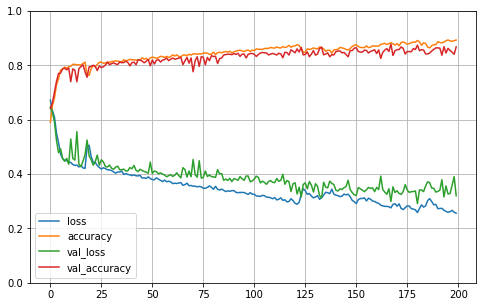

accuracy: 86.78%

Validation core mean 86.78% (+/- 0.00%)


In [8]:
MINLEN=200
MAXLEN=1000

print("Working on full training set, slice by sequence length.")
print("Slice size range [%d - %d)"%(MINLEN,MAXLEN))
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y

print ("Sequence to Kmer")
(X_train,y_train)=make_kmers(MINLEN,MAXLEN,subset)
print ("Compile the model")
model=build_model(MAXLEN,EMBED_DIMEN)
print(model.summary())  # Print this only once
print ("Cross valiation")
model1=do_cross_validation(X_train,y_train,EPOCHS,MAXLEN,EMBED_DIMEN)

## Len 1K-2Kb

Working on full training set, slice by sequence length.
Slice size range [1000 - 2000)
original (30290, 4)
no short (9273, 4)
no long, no short (3368, 4)
Sequence to Kmer
<class 'pandas.core.frame.DataFrame'>
(3368, 1)
sequence    GGCGGGGTCGACTGACGGTAACGGGGCAGAGAGGCTGTTCGCAGAG...
Name: 12641, dtype: object
1338
transform...
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
[[42 39 27 ...  0  0  0]
 [57 34  5 ...  0  0  0]
 [27 44 47 ...  0  0  0]
 ...
 [44 47 57 ...  0  0  0]
 [10 37 20 ...  0  0  0]
 [47 60 48 ...  0  0  0]]
Compile the model
COMPILE
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2000, 16)          1040      
_________________________________________________________________
bidirectional_4 (Bidirection (None, 2000, 64)          9600      
_________________________________________________________________
bidirectiona

85/85 [==============================] - 232s 3s/step - loss: 0.3746 - accuracy: 0.8400 - val_loss: 0.3591 - val_accuracy: 0.8435
Epoch 47/200
85/85 [==============================] - 237s 3s/step - loss: 0.3721 - accuracy: 0.8415 - val_loss: 0.3646 - val_accuracy: 0.8489
Epoch 48/200
85/85 [==============================] - 238s 3s/step - loss: 0.3769 - accuracy: 0.8342 - val_loss: 0.3532 - val_accuracy: 0.8502
Epoch 49/200
85/85 [==============================] - 241s 3s/step - loss: 0.3664 - accuracy: 0.8438 - val_loss: 0.3522 - val_accuracy: 0.8393
Epoch 50/200
85/85 [==============================] - 241s 3s/step - loss: 0.3722 - accuracy: 0.8379 - val_loss: 0.3523 - val_accuracy: 0.8486
Epoch 51/200
85/85 [==============================] - 241s 3s/step - loss: 0.3698 - accuracy: 0.8409 - val_loss: 0.3577 - val_accuracy: 0.8491
Epoch 52/200
85/85 [==============================] - 240s 3s/step - loss: 0.3619 - accuracy: 0.8441 - val_loss: 0.3498 - val_accuracy: 0.8426
Epoch 53/200

Epoch 160/200
85/85 [==============================] - 242s 3s/step - loss: 0.3051 - accuracy: 0.8703 - val_loss: 0.3552 - val_accuracy: 0.8375
Epoch 161/200
85/85 [==============================] - 241s 3s/step - loss: 0.2957 - accuracy: 0.8836 - val_loss: 0.3675 - val_accuracy: 0.8314
Epoch 162/200
85/85 [==============================] - 241s 3s/step - loss: 0.2981 - accuracy: 0.8779 - val_loss: 0.3322 - val_accuracy: 0.8610
Epoch 163/200
85/85 [==============================] - 241s 3s/step - loss: 0.2972 - accuracy: 0.8756 - val_loss: 0.3313 - val_accuracy: 0.8634
Epoch 164/200
85/85 [==============================] - 236s 3s/step - loss: 0.3031 - accuracy: 0.8726 - val_loss: 0.3670 - val_accuracy: 0.8411
Epoch 165/200
85/85 [==============================] - 232s 3s/step - loss: 0.3032 - accuracy: 0.8711 - val_loss: 0.3659 - val_accuracy: 0.8316
Epoch 166/200
85/85 [==============================] - 238s 3s/step - loss: 0.2982 - accuracy: 0.8778 - val_loss: 0.3335 - val_accuracy:

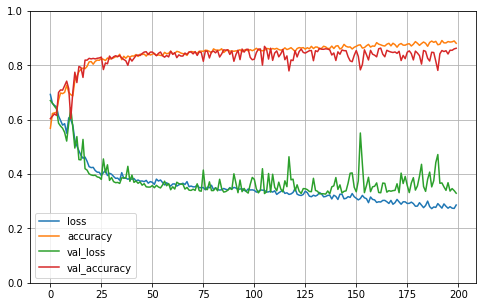

accuracy: 86.29%

Validation core mean 86.29% (+/- 0.00%)


In [9]:
MINLEN=1000
MAXLEN=2000

print("Working on full training set, slice by sequence length.")
print("Slice size range [%d - %d)"%(MINLEN,MAXLEN))
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y

print ("Sequence to Kmer")
(X_train,y_train)=make_kmers(MINLEN,MAXLEN,subset)
print ("Compile the model")
model=build_model(MAXLEN,EMBED_DIMEN)
print(model.summary())  # Print this only once
print ("Cross valiation")
model2=do_cross_validation(X_train,y_train,EPOCHS,MAXLEN,EMBED_DIMEN)

## Len 2K-3Kb

Working on full training set, slice by sequence length.
Slice size range [2000 - 3000)
original (30290, 4)
no short (3221, 4)
no long, no short (1351, 4)
Sequence to Kmer
<class 'pandas.core.frame.DataFrame'>
(1351, 1)
sequence    GTCATTCTAGCTGCCTGCTGCCTCCGCAGCGTCCCCCCAGCTCTCC...
Name: 19713, dtype: object
2039
transform...
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
[[46 53 20 ...  0  0  0]
 [ 3 10 37 ...  0  0  0]
 [12 48 62 ...  0  0  0]
 ...
 [13 49  3 ...  0  0  0]
 [39 25 33 ...  0  0  0]
 [ 9 36 15 ...  0  0  0]]
Compile the model
COMPILE
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 3000, 16)          1040      
_________________________________________________________________
bidirectional_8 (Bidirection (None, 3000, 64)          9600      
_________________________________________________________________
bidirectiona

34/34 [==============================] - 173s 5s/step - loss: 0.2905 - accuracy: 0.8804 - val_loss: 0.3259 - val_accuracy: 0.8692
Epoch 47/200
34/34 [==============================] - 173s 5s/step - loss: 0.2688 - accuracy: 0.8928 - val_loss: 0.3142 - val_accuracy: 0.8704
Epoch 48/200
34/34 [==============================] - 169s 5s/step - loss: 0.2678 - accuracy: 0.8971 - val_loss: 0.3123 - val_accuracy: 0.8668
Epoch 49/200
34/34 [==============================] - 172s 5s/step - loss: 0.2593 - accuracy: 0.8960 - val_loss: 0.3134 - val_accuracy: 0.8693
Epoch 50/200
34/34 [==============================] - 172s 5s/step - loss: 0.2627 - accuracy: 0.8986 - val_loss: 0.3104 - val_accuracy: 0.8667
Epoch 51/200
34/34 [==============================] - 170s 5s/step - loss: 0.2490 - accuracy: 0.9032 - val_loss: 0.3533 - val_accuracy: 0.8409
Epoch 52/200
34/34 [==============================] - 168s 5s/step - loss: 0.2746 - accuracy: 0.8831 - val_loss: 0.3111 - val_accuracy: 0.8618
Epoch 53/200

Epoch 160/200
34/34 [==============================] - 169s 5s/step - loss: 0.5124 - accuracy: 0.7411 - val_loss: 0.5595 - val_accuracy: 0.6835
Epoch 161/200
34/34 [==============================] - 165s 5s/step - loss: 0.5096 - accuracy: 0.7415 - val_loss: 0.5493 - val_accuracy: 0.6954
Epoch 162/200
34/34 [==============================] - 165s 5s/step - loss: 0.5053 - accuracy: 0.7450 - val_loss: 0.5284 - val_accuracy: 0.7112
Epoch 163/200
34/34 [==============================] - 165s 5s/step - loss: 0.4967 - accuracy: 0.7520 - val_loss: 0.5291 - val_accuracy: 0.7084
Epoch 164/200
34/34 [==============================] - 165s 5s/step - loss: 0.4934 - accuracy: 0.7535 - val_loss: 0.5183 - val_accuracy: 0.7396
Epoch 165/200
34/34 [==============================] - 166s 5s/step - loss: 0.4925 - accuracy: 0.7536 - val_loss: 0.5284 - val_accuracy: 0.6981
Epoch 166/200
34/34 [==============================] - 166s 5s/step - loss: 0.4842 - accuracy: 0.7563 - val_loss: 0.5379 - val_accuracy:

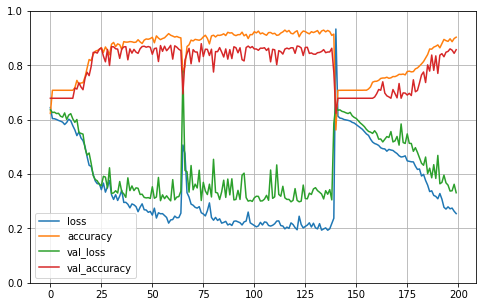

accuracy: 85.76%

Validation core mean 85.76% (+/- 0.00%)


In [10]:
MINLEN=2000
MAXLEN=3000

print("Working on full training set, slice by sequence length.")
print("Slice size range [%d - %d)"%(MINLEN,MAXLEN))
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y

print ("Sequence to Kmer")
(X_train,y_train)=make_kmers(MINLEN,MAXLEN,subset)
print ("Compile the model")
model=build_model(MAXLEN,EMBED_DIMEN)
print(model.summary())  # Print this only once
print ("Cross valiation")
model3=do_cross_validation(X_train,y_train,EPOCHS,MAXLEN,EMBED_DIMEN)

In [11]:
model1.save('EMB30.Short.model')
model2.save('EMB30.Medium.model')
model3.save('EMB30.Long.model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: EMB30.Short.model/assets
INFO:tensorflow:Assets written to: EMB30.Medium.model/assets
INFO:tensorflow:Assets written to: EMB30.Long.model/assets
